# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [3]:
from sklearn.datasets import make_circles, make_moons, load_breast_cancer, make_regression, load_diabetes
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split

# Code

In [4]:
class Booster:
    
    def __init__(self, learning_rate: int, n_estimators: int):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators = []
        
    def _fit_first_estimator(self, X, y):
        raise NotImplementedError
    
    def fit(self, X, y):
        raise NotImplementedError
    
    def predict(self, X):
        raise NotImplementedError

In [5]:
class BoostingRegressor(Booster):
    
    def __init__(self, max_depth: int, **kwargs):
        super().__init__(**kwargs)
        self.first_estimator = None
        self.max_depth = max_depth
    
    def _fit_first_estimator(self, X, y):
        self.first_estimator = LinearRegression()
        self.first_estimator.fit(X, y)
    
    def _fit_base_estimator(self, X, y):
        model = DecisionTreeRegressor(max_depth=self.max_depth)
        model.fit(X, y)
        return model
        
    def fit(self, X, y):
        self._fit_first_estimator(X, y)
        
        for i in range(1, self.n_estimators):
            y_pred = self.first_estimator.predict(X)
            for estimator in self.estimators:
                y_pred += self.learning_rate * estimator.predict(X)
            model = self._fit_base_estimator(X, self.derivate_loss(y, y_pred))
            self.estimators.append(model)
            
    
    def derivate_loss(self, y_true, y_pred):
        'MSE loss derivate'
        return y_true - y_pred
    
    def predict(self, X):
        y_pred = self.first_estimator.predict(X)
        for estimator in self.estimators:
            y_pred += self.learning_rate * estimator.predict(X)
        return y_pred

In [6]:
class BoostingClassifier(Booster):
    """
    Binary classifier
    """
    
    def __init__(self, max_depth: int, random_state: int = 0, **kwargs):
        super().__init__(**kwargs)
        self.first_estimator = None
        self.max_depth = max_depth
        self.random_state = random_state
    
    def _fit_first_estimator(self, X, y):
        self.first_estimator = LinearRegression()
        self.first_estimator.fit(X, y)
    
    def _fit_base_estimator(self, X, y):
        model = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
        model.fit(X, y)
        return model
        
    def fit(self, X, y):
        self._fit_first_estimator(X, y)
        
        for i in range(1, self.n_estimators):
            y_pred = self.first_estimator.predict(X)
            for estimator in self.estimators:
                y_pred += self.learning_rate * (estimator.predict(X))
            model = self._fit_base_estimator(X, self.derivate_loss(y, y_pred))
            self.estimators.append(model)
            
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def derivate_loss(self, y_true, y_pred):
        'Log loss derivate'
        return y_true - self._sigmoid(y_pred)
    
    def predict_proba(self, X):
        y_pred = self.first_estimator.predict(X)
        for estimator in self.estimators:
            y_pred += self.learning_rate * (estimator.predict(X))
        return self._sigmoid(y_pred)
    
    def predict(self, X):
        preds = self.predict_proba(X)
        return np.round(preds)

## Helpers

In [7]:
def plot_mesh_grid(clf_list, X, y):
    i = 1
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
    for clf in clf_list:
        plt.subplot(1, 2, i)
    
        eps = 0.3

        xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 100),
                             np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 100))
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()][:, :]).reshape(xx.shape)

        plt.pcolormesh(xx, yy, z, cmap='Spectral', shading='auto')
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral', edgecolors='black')
        plt.title(clf)
        
        i+=1

In [8]:
def fit_ensemble(X, y, task):
    
    if task == 'clf':
    
        my_grad = BoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)

        sk_grad = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
        
    else:
        
        my_grad = BoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)

        sk_grad = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
    
    my_grad.fit(X, y)
    sk_grad.fit(X, y)
    
    return my_grad, sk_grad

## Classification

### Moons

In [9]:
X, y = make_moons(300, noise=0.2, random_state=42)

In [10]:
my_grad, sk_grad = fit_ensemble(X, y, 'clf')

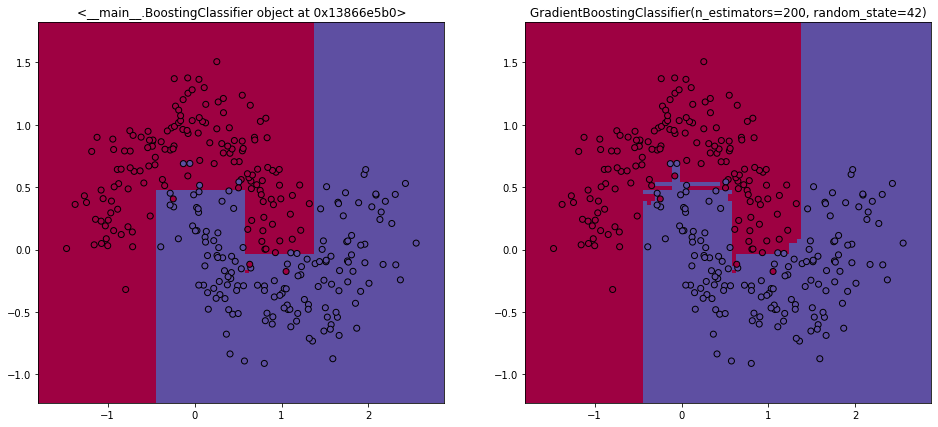

In [11]:
plot_mesh_grid([my_grad, sk_grad], X, y)

### Circles

In [12]:
X, y = make_circles(300, noise=0.2, random_state=42, factor=0.2)

In [13]:
my_grad, sk_grad = fit_ensemble(X, y, 'clf')

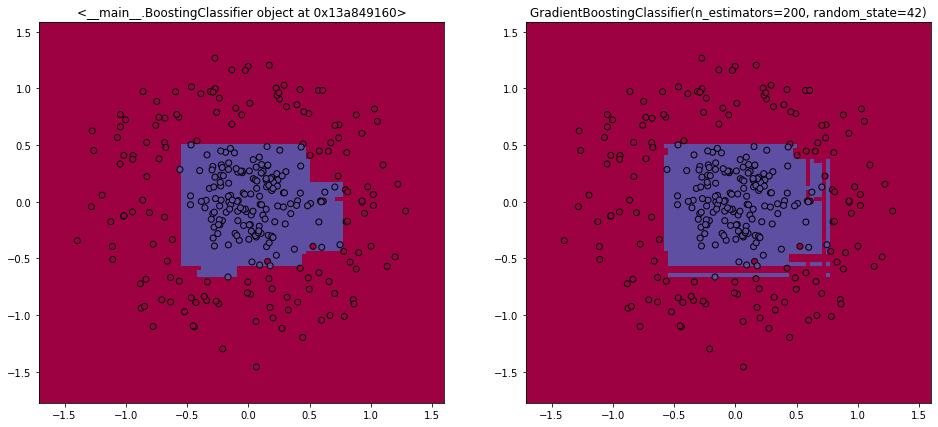

In [14]:
plot_mesh_grid([my_grad, sk_grad], X, y)

### Breast cancer

In [15]:
X, y = load_breast_cancer().data, load_breast_cancer().target

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
my_grad, sk_grad = fit_ensemble(X_train, y_train, 'clf')

In [17]:
print(classification_report(y_test, my_grad.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        63
           1       0.98      0.97      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [18]:
print(classification_report(y_test, sk_grad.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        63
           1       0.96      0.96      0.96       108

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



## Regression

### sin

In [19]:
def F(x):
    return 3*np.sin(x*2)

In [20]:
X = np.linspace(-3,3)
y = F(X) + np.random.randn(len(X))
X = X.reshape(-1,1)

In [21]:
my_grad, sk_grad = fit_ensemble(X, y, 'reg')

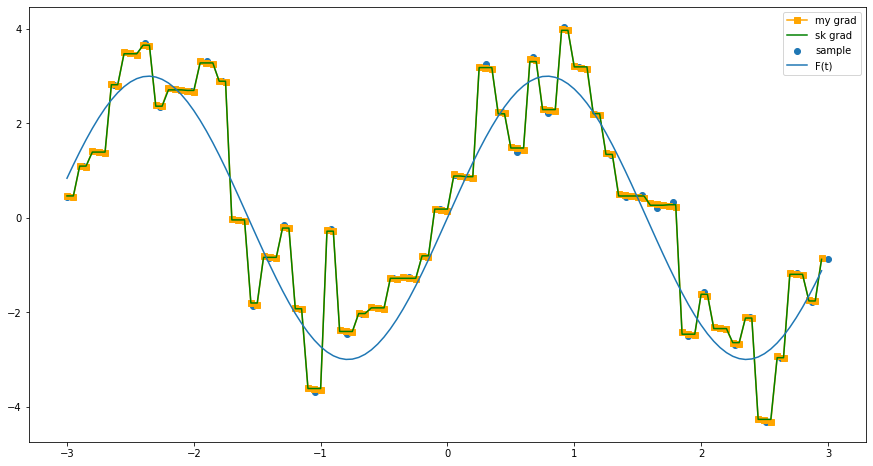

In [22]:
plt.figure(figsize=(15,8))
t = np.arange(-3, 3, 0.05).reshape(-1,1)
pred_my = my_grad.predict(t)
pred_sk = sk_grad.predict(t)
plt.plot(t, pred_my, color='orange', label='my grad', marker='s')
plt.plot(t, pred_sk, color='green', label='sk grad')
plt.scatter(X, y, label='sample')
plt.plot(t, F(t), label='F(t)')
plt.legend()

### diabets

In [23]:
X, y = load_diabetes().data, load_diabetes().target

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
my_grad, sk_grad = fit_ensemble(X_train, y_train, 'reg')

In [25]:
mean_squared_error(y_test, my_grad.predict(X_test))

3554.1061259670764

In [26]:
mean_squared_error(y_test, sk_grad.predict(X_test))

3291.8206401409952

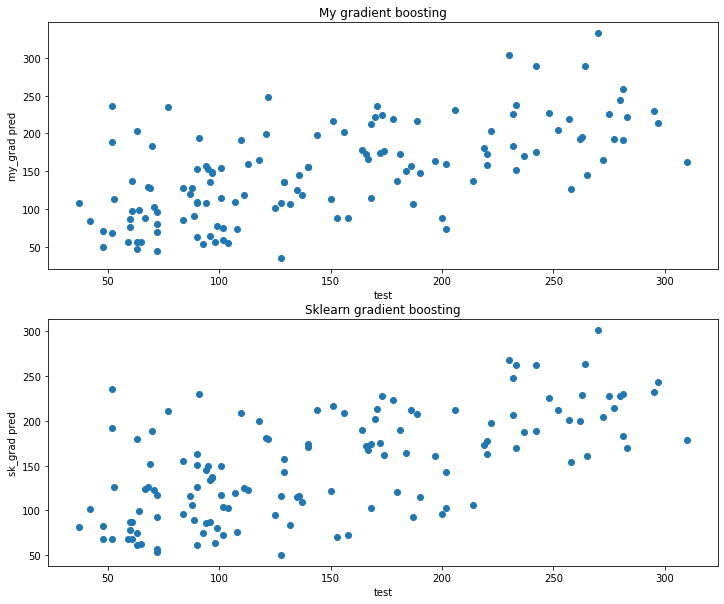

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(12,10))

plt.subplot(2, 1, 1)
plt.title('My gradient boosting')
plt.scatter(y_test, my_grad.predict(X_test))
plt.xlabel('test')
plt.ylabel('my_grad pred')

plt.subplot(2, 1, 2)
plt.title('Sklearn gradient boosting')
plt.scatter(y_test, sk_grad.predict(X_test))
plt.xlabel('test')
plt.ylabel('sk_grad pred')

plt.show()